# **Preparación entorno**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Establecemos ruta
%cd /content/drive/MyDrive/TFM/data

/content/drive/MyDrive/TFM/data


In [ ]:
import pandas as pd
import numpy as np

#Cargamos datasets de calcificaciones
calc_train = pd.read_csv('calc_case_description_train_set.csv')
calc_test = pd.read_csv('calc_case_description_test_set.csv')

In [ ]:
# Verificamos que ambos datasets tengan las mismas columnas
print("Train:\n", calc_train.columns)
print("Test:\n", calc_test.columns)

Train:
 Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')
Test:
 Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')


In [ ]:
# Concatenamos en un solo dataframe
calc_df = pd.concat([calc_train, calc_test], axis=0).reset_index(drop=True)
calc_df.shape

(1872, 14)

# **Cargamos rutas de las imagenes a los datos tabulares**

In [ ]:
# Instalamos la librería necesaría para leer las imagenes médicas
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.8 MB/s eta 0:00:00


ROI shape: (5056, 2761) Vals: [  0 255]
Crop shape: (589, 677) Vals: [20012 20087 20112 ... 60027 64294 65535]


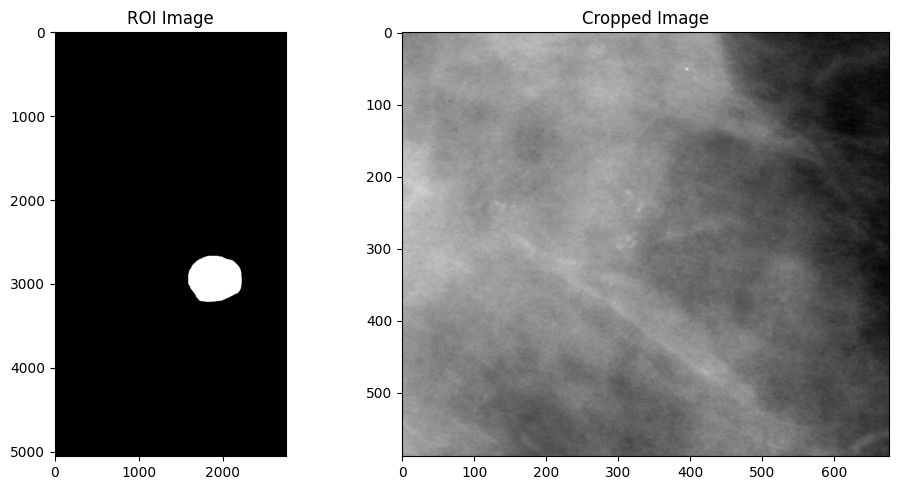

In [ ]:
import pydicom
import matplotlib.pyplot as plt

# Cargamos dos imagenes de ejemplo
roi_path = "Example_ROI.dcm"
crop_path = "Example_CROP.dcm"

# Leemos las imágenes
roi_img = pydicom.dcmread(roi_path).pixel_array
crop_img = pydicom.dcmread(crop_path).pixel_array

# Mostramos valores únicos y formas
print("ROI shape:", roi_img.shape, "Vals:", np.unique(roi_img))
print("Crop shape:", crop_img.shape, "Vals:", np.unique(crop_img))

# Visualizamos
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(roi_img, cmap="gray")
axs[0].set_title("ROI Image")
axs[1].imshow(crop_img, cmap="gray")
axs[1].set_title("Cropped Image")
plt.tight_layout()
plt.show()

In [ ]:
import os

# Ruta base con todas las carpetas
base_dir = "/content/drive/MyDrive/TFM/data/CBIS-DDSM"

# Actualizamos la ruta de la imagen
def image_update_path(folder_path):
    """
    Busca de forma recursiva en una carpeta (y subcarpetas) el primer archivo dcm encontrado.
    Usado solo para image file path.
    """
    if os.path.isdir(folder_path):
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".dcm"):
                    return os.path.join(root, file)
    return None

# Actualizamos las rutas para las imagenes CROP y ROI según los valores de píxel
def ROI_CROP_update_path(folder_path):
    """
    Busca recursivamente todos los dcm en una carpeta.
    Si el array de píxeles contiene únicamente [0, 255] se considera ROI.
    Si no se considera crop.
    """
    crop_path, roi_path = None, None
    if os.path.isdir(folder_path):
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".dcm"):
                    dcm_path = os.path.join(root, file)
                    try:
                        ds = pydicom.dcmread(dcm_path)
                        values = np.unique(ds.pixel_array)
                        if  np.array_equal(values, [0, 255]):
                            roi_path = dcm_path
                        else:
                            crop_path = dcm_path
                    except Exception as e:
                        print(f"Error leyendo {dcm_path}: {e}")
    return crop_path, roi_path


# Bucle para actualizar las rutas en el DataFrame
for idx, row in calc_df.iterrows():

    # 1. Imagen completa
    if isinstance(row['image file path'], str):
        folder_name = row['image file path'].split('/')[0]
        folder_path = os.path.join(base_dir, folder_name)

        image_dcm = image_update_path(folder_path)
        if image_dcm:
            calc_df.at[idx, 'image file path'] = image_dcm
        else:
            print(f"[INFO] No se encontró imagen completa en {folder_path}")

    # 2. Imagen recortada (CROP)
    if isinstance(row['cropped image file path'], str):
        crop_folder = row['cropped image file path'].split('/')[0]
        crop_folder_path = os.path.join(base_dir, crop_folder)

        crop_path, _ = ROI_CROP_update_path(crop_folder_path)
        if crop_path:
            calc_df.at[idx, 'cropped image file path'] = crop_path

    # 3. Máscara ROI
    if isinstance(row['ROI mask file path'], str):
        roi_folder = row['ROI mask file path'].split('/')[0]
        roi_folder_path = os.path.join(base_dir, roi_folder)

        _, roi_path = ROI_CROP_update_path(roi_folder_path)
        if roi_path:
            calc_df.at[idx, 'ROI mask file path'] = roi_path

In [ ]:
calc_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...


In [ ]:
# Ruta completa de destino
output_path = "/content/drive/MyDrive/TFM/data/calc_df.csv"

# Guardamos el DataFrame actualizado
calc_df.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: /content/drive/MyDrive/TFM/data/calc_df.csv
